<font size="+3"><strong>Volatility Forecasting </strong></font>

Building a model to predict volatility.

**1:** Importing libraries.

In [9]:
# Import your libraries 
%load_ext autoreload
%autoreload 2

import os
import sqlite3

import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import requests
from arch import arch_model
from arch.univariate.base import ARCHModelResult
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


from config import settings
from data import SQLRepository

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Downloading Data

**2:** Getting all the data available.

In [5]:
# Define the upro symbol
ticker = 'UPRO'  

# Download historical data with maximum available period
upro_data = yf.download(ticker, period='max')

# Drop the 'Adj Close' column
upro_data = upro_data.drop(columns=['Adj Close'])

# Display the first few rows of the updated data
print(upro_data.head())
print(upro_data.tail())

# Save the data to a CSV file
upro_data.to_csv(f'{ticker}_historical_data.csv')


[*********************100%%**********************]  1 of 1 completed

                Open      High       Low     Close    Volume
Date                                                        
2009-06-25  1.126250  1.210417  1.126250  1.205556   2577600
2009-06-26  1.195278  1.213056  1.177361  1.199306  13104000
2009-06-29  1.208333  1.236111  1.191389  1.233333   8690400
2009-06-30  1.233333  1.243333  1.176389  1.203889  17128800
2009-07-01  1.218472  1.252917  1.213611  1.216806  12038400
                 Open       High        Low      Close   Volume
Date                                                           
2024-08-26  82.239998  82.570000  80.470001  81.169998  3301300
2024-08-27  80.610001  81.730003  80.129997  81.510002  2652600
2024-08-28  81.360001  81.529999  78.639999  80.070000  3505000
2024-08-29  80.900002  82.339996  79.559998  80.029999  5456700
2024-08-30  80.989998  82.449997  79.430000  82.199997  4147100


# Prepare Data

**3:** Creating a DataFrame.

In [6]:
df_upro = pd.DataFrame(upro_data)

# Ensuring the index is a datetime index
df_upro.index = pd.to_datetime(df_upro.index)

# Converting all column names to lowercase
df_upro.columns = df_upro.columns.str.lower()

# Ensuring 'Date' column is named 'date' for consistency
df_upro.index.name = 'date'

print("df_upro type:", type(df_upro))
df_upro.head()


df_upro type: <class 'pandas.core.frame.DataFrame'>


,open,high,low,close,volume
date,,,,,
2009-06-25,1.126250,1.210417,1.126250,1.205556,2577600
2009-06-26,1.195278,1.213056,1.177361,1.199306,13104000
2009-06-29,1.208333,1.236111,1.191389,1.233333,8690400
2009-06-30,1.233333,1.243333,1.176389,1.203889,17128800
2009-07-01,1.218472,1.252917,1.213611,1.216806,12038400


**4:** Checking for any null values and removing the null values.

In [7]:
print('Null Values =',df_upro.isnull().values.any())
df_upro.head()

Null Values = False


,open,high,low,close,volume
date,,,,,
2009-06-25,1.126250,1.210417,1.126250,1.205556,2577600
2009-06-26,1.195278,1.213056,1.177361,1.199306,13104000
2009-06-29,1.208333,1.236111,1.191389,1.233333,8690400
2009-06-30,1.233333,1.243333,1.176389,1.203889,17128800
2009-07-01,1.218472,1.252917,1.213611,1.216806,12038400


**5:** Creating a visualization of the closing price.

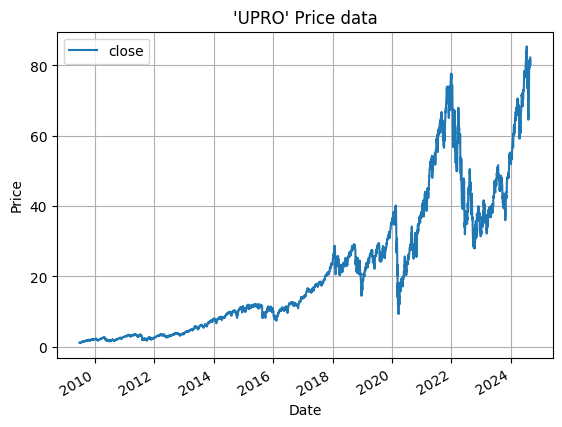

In [8]:
df_upro[['close']].plot(grid=True)

# Adding axis labels
plt.xlabel("Date")
plt.ylabel("Price")

# Adding title
plt.title(f"'{ticker}' Price data")
plt.show();


**6:** Connecting to the database whose name is stored in the `.env` file.

In [10]:
connection = sqlite3.connect(database=settings.db_name, check_same_thread=False)
connection

**7:** Inserting data into database.

In [11]:
# Inserting data into database
repo = SQLRepository(connection=connection)
response = repo.insert_table(table_name=ticker, records=df_upro, if_exists="replace")

**8:** Reading the table from the database and assigning the output.

In [12]:
df_upro_read = pd.read_sql(
    sql="SELECT * FROM 'UPRO'", con=connection, parse_dates=["date"], index_col="date"
)

print("df_upro_read type:", type(df_upro_read))
print("df_upro_read shape:", df_upro_read.shape)
df_upro_read.tail()

df_upro_read type: <class 'pandas.core.frame.DataFrame'>
df_upro_read shape: (3822, 5)


,open,high,low,close,volume
date,,,,,
2024-08-26,82.239998,82.570000,80.470001,81.169998,3301300
2024-08-27,80.610001,81.730003,80.129997,81.510002,2652600
2024-08-28,81.360001,81.529999,78.639999,80.070000,3505000
2024-08-29,80.900002,82.339996,79.559998,80.029999,5456700
2024-08-30,80.989998,82.449997,79.430000,82.199997,4147100


# Predicting Volatility

**9:** Creating a Series with the 2,500 most recent returns.

In [13]:
def wrangle_data(ticker, n_observations):

    """Extract table data from database. Calculate returns.

    Parameters
    ----------
    ticker : str
        The ticker symbol of the upro (also table name in database).

    n_observations : int
        Number of observations to return.

    Returns
    -------
    pd.Series
        Name will be `"return"`. There will be no `NaN` values.
    """
    # Geting table from database
    df = repo.read_table(table_name=ticker, limit=n_observations+1)
    
    # Sorting DataFrame ascending by date
    df.sort_index(ascending=True, inplace=True)
    
    # Creating "return" column
    df["return"] = df["close"].pct_change() * 100

    # Returning returns
    return df["return"].dropna()

In [14]:
df_upro = repo.read_table(table_name="UPRO", limit=2500)

print("df_upro type:", type(df_upro))
print("df_upro shape:", df_upro.shape)


df_upro type: <class 'pandas.core.frame.DataFrame'>
df_upro shape: (2500, 5)


In [15]:
y_upro = wrangle_data(ticker="UPRO", n_observations=2500)

print("y_upro type:", type(y_upro))
print("y_upro shape:", y_upro.shape)
print(y_upro.tail())
print(y_upro.head())

y_upro type: <class 'pandas.core.series.Series'>
y_upro shape: (2500,)
date
2024-08-26   -0.782300
2024-08-27    0.418879
2024-08-28   -1.766657
2024-08-29   -0.049957
2024-08-30    2.711481
Name: return, dtype: float64
date
2014-09-25   -4.854296
2014-09-26    2.443431
2014-09-29   -0.621481
2014-09-30   -0.819742
2014-10-01   -4.021805
Name: return, dtype: float64


**10:** Calculating daily volatility, and assigning the result.

In [16]:
upro_daily_volatility = y_upro.std()

print("upro_daily_volatility type:", type(upro_daily_volatility))
print("UPRO Daily Volatility:", upro_daily_volatility)


upro_daily_volatility type: <class 'numpy.float64'>
UPRO Daily Volatility: 3.3544369821937385


**11:** Calculating the annual volatility, and assign the result.

In [17]:
upro_annual_volatility = upro_daily_volatility * np.sqrt(252)

print("upro_annual_volatility type:", type(upro_annual_volatility))
print("UPRO Annual Volatility:", upro_annual_volatility)

upro_annual_volatility type: <class 'numpy.float64'>
UPRO Annual Volatility: 53.2500362611358


**12:** Creating a time series line plot.

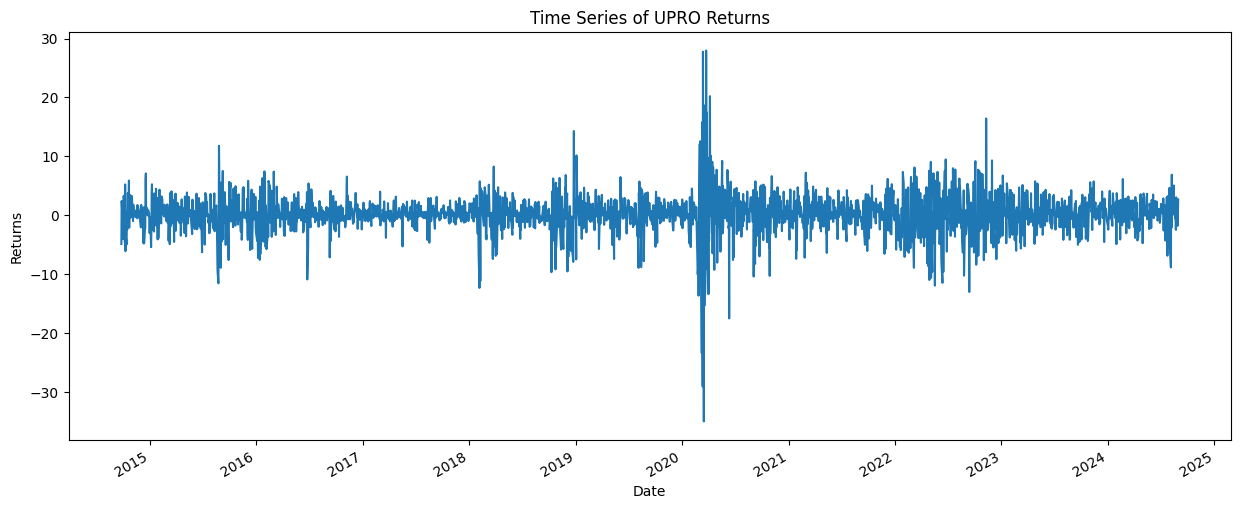

In [18]:
# Creating `fig` and `ax`
fig, ax = plt.subplots(figsize=(15, 6))

# Ploting on `ax`
y_upro.plot(ax=ax, label="daily return")

# Adding axis labels
plt.xlabel("Date")
plt.ylabel("Returns")

# Add title
plt.title(f"Time Series of {ticker} Returns");

**13:** Creating an ACF plot of the squared returns.

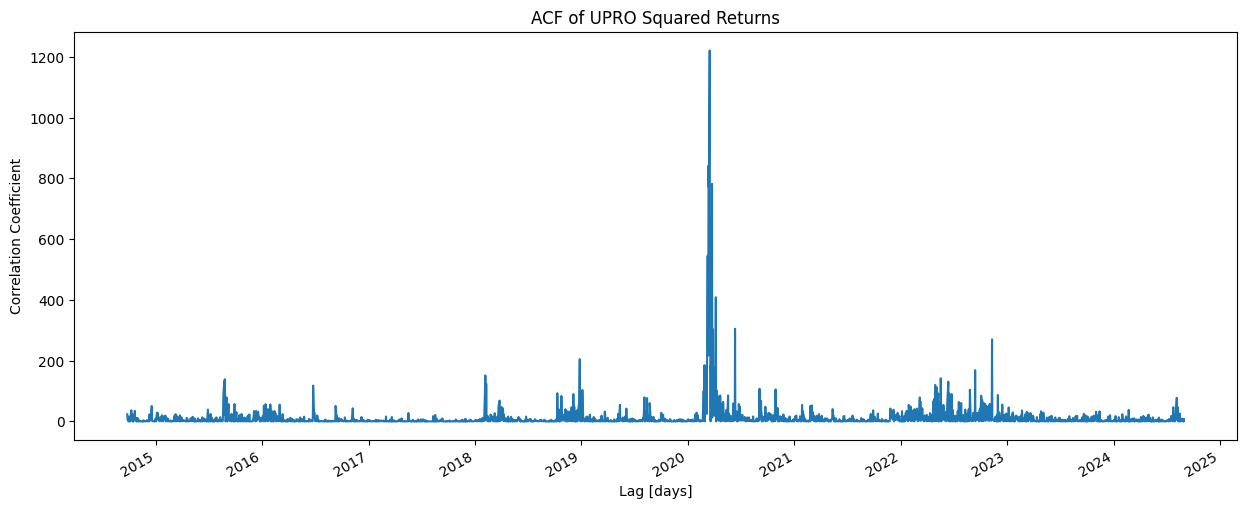

In [19]:
# Creating `fig` and `ax`
fig, ax = plt.subplots(figsize=(15, 6))

# Creating ACF of squared returns
(y_upro**2).plot(ax=ax)

# Adding axis labels
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient")

# Adding title
plt.title(f"ACF of {ticker} Squared Returns");


**14:** Creating a PACF plot of the squared returns.

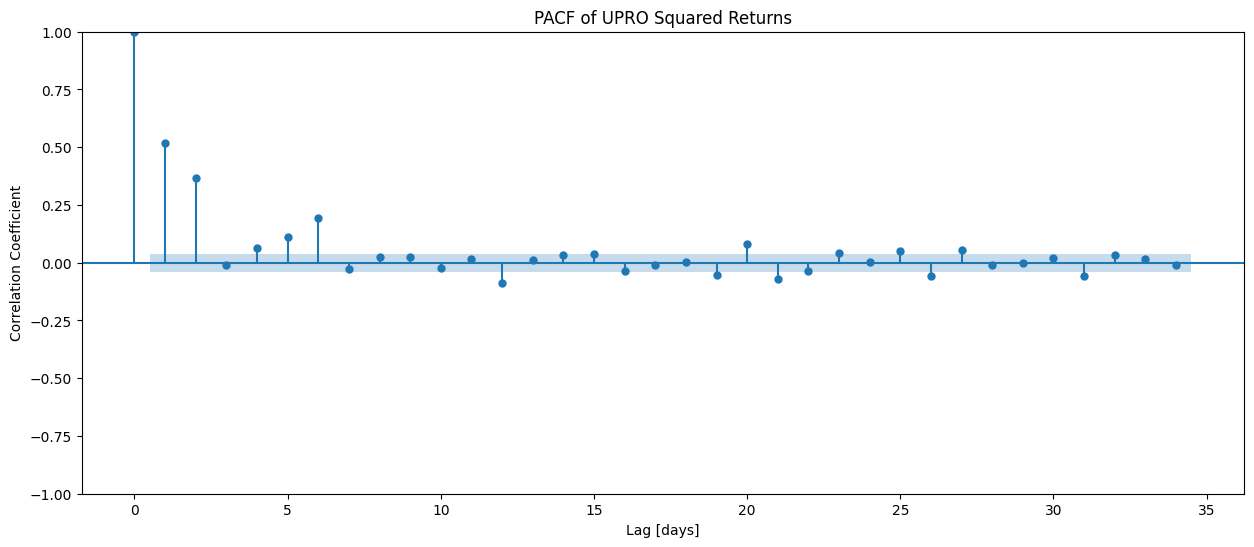

In [20]:
# Creating `fig` and `ax`
fig, ax = plt.subplots(figsize=(15, 6))

# Creating PACF of squared returns
plot_pacf(y_upro**2, ax=ax)

# Adding axis labels
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient")

# Adding title
plt.title(f"PACF of {ticker} Squared Returns");


**15:** Creating a training set that contains the first 80% of the observations.

In [21]:
print(y_upro.tail())
print(y_upro.head())

date
2024-08-26   -0.782300
2024-08-27    0.418879
2024-08-28   -1.766657
2024-08-29   -0.049957
2024-08-30    2.711481
Name: return, dtype: float64
date
2014-09-25   -4.854296
2014-09-26    2.443431
2014-09-29   -0.621481
2014-09-30   -0.819742
2014-10-01   -4.021805
Name: return, dtype: float64


In [22]:
cutoff_test = int(len(y_upro) * 0.8)
print(cutoff_test)
y_upro_train = y_upro.iloc[:cutoff_test]
y_upro_test = y_upro.iloc[cutoff_test:]

print("y_upro_train type:", type(y_upro_train))
print("y_upro_train shape:", y_upro_train.shape)
print(y_upro_train.tail(1))
print(y_upro_train.head(1))
print(y_upro_test.tail(1))
print(y_upro_test.head(1))


2000
y_upro_train type: <class 'pandas.core.series.Series'>
y_upro_train shape: (2000,)
date
2022-09-02   -3.136954
Name: return, dtype: float64
date
2014-09-25   -4.854296
Name: return, dtype: float64
date
2024-08-30    2.711481
Name: return, dtype: float64
date
2022-09-06   -1.184836
Name: return, dtype: float64


## Build Model

**16:** Building and fiting a GARCH model using the data.

In [23]:
# Building and training model
model = arch_model(
    y_upro_train,
    p=1,
    q=1,
    rescale=False
).fit(disp=0)

print("model type:", type(model))

# Showing model summary
model.summary()


model type: <class 'arch.univariate.base.ARCHModelResult'>


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4711.68
Distribution:                  Normal   AIC:                           9431.36
Method:            Maximum Likelihood   BIC:                           9453.76
                                        No. Observations:                 2000
Date:                Mon, Sep 02 2024   Df Residuals:                     1999
Time:                        21:07:04   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.2643  4.744e-02      5.571  2.530e-08 [  0.171,  0.357]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.3664  9.332e-02      3.926  8.633e-05 [  0.183,  0.549]
alpha[1]       0.2354  3.592e-02      6.552  5.662e-11 [  0.165,  0.306]
beta[1]        0.7411  3.024e-02     24.505 1.306e-132 [  0.682,  0.800]
========================================================================

Covariance estimator: robust
"""

**17:** Ploting the standardized residuals for the `model`.

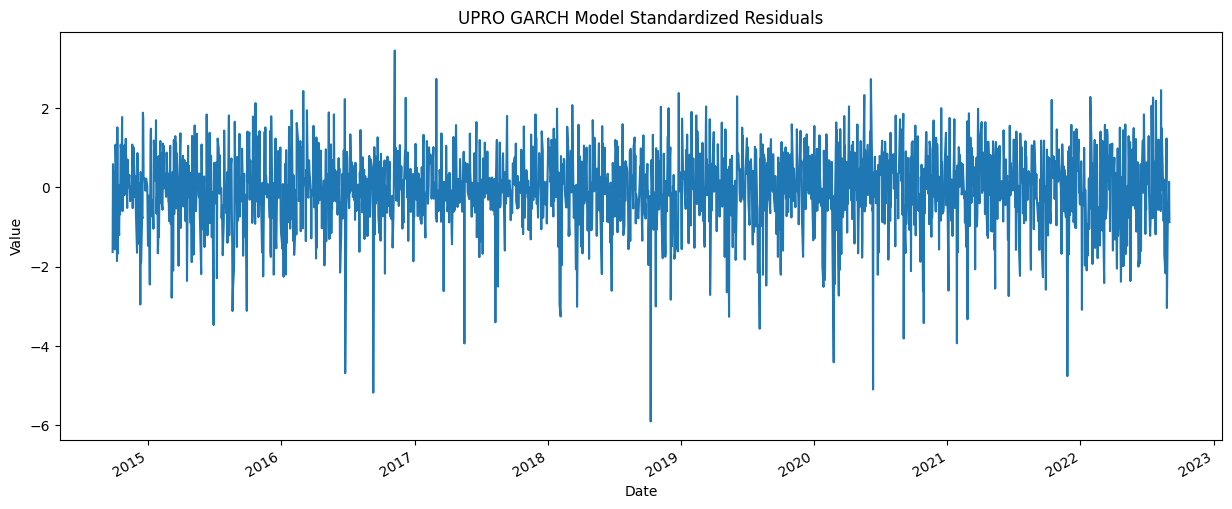

In [24]:
# Creating `fig` and `ax`
fig, ax = plt.subplots(figsize=(15, 6))

# Ploting standardized residuals
model.std_resid.plot(ax=ax, label="Standardized Residuals")

# Adding axis labels
plt.xlabel("Date")
plt.ylabel("Value")

# Adding title
plt.title(f"{ticker} GARCH Model Standardized Residuals");


**18:** Creating an ACF plot of the squared, standardized residuals of the model.

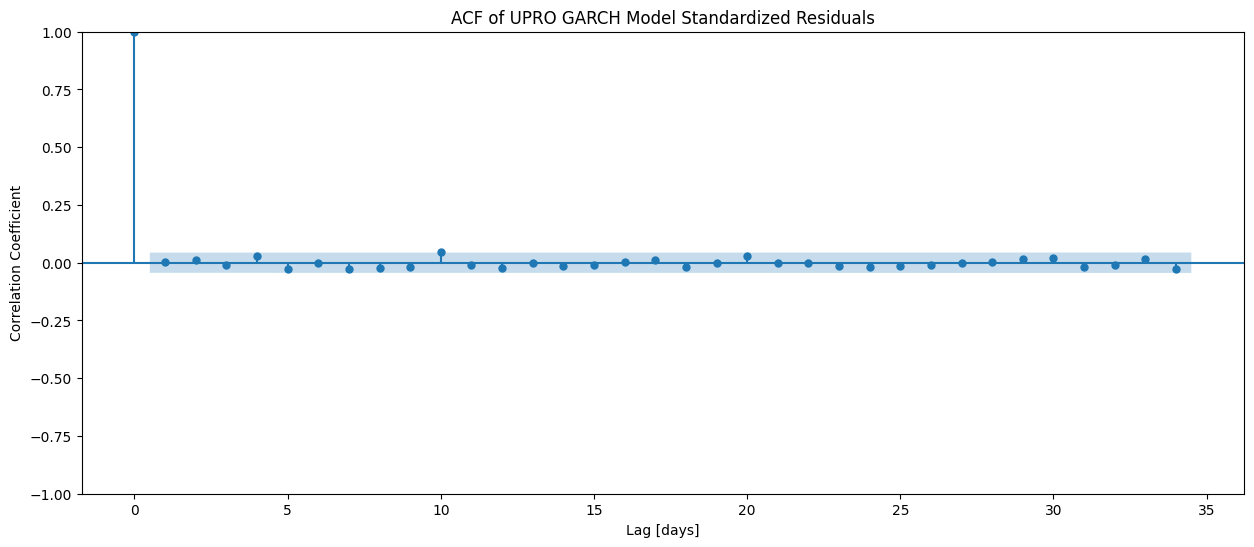

In [25]:
# Creating `fig` and `ax`
fig, ax = plt.subplots(figsize=(15, 6))

# Creating ACF of squared, standardized residuals
plot_acf(model.std_resid**2, ax=ax)

# Adding axis labels
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient")

# Adding title
plt.title(f"ACF of {ticker} GARCH Model Standardized Residuals");


**18:** Generate forecasts from the model.

In [26]:
# Generate forecasts from the model
# `horizon=1` means forecasting 1 steps ahead
forecast = model.forecast(horizon=1)

# Accessing the forecasted conditional variances
# .variance returns a DataFrame with the predicted variances
variance_forecasts = forecast.variance

# To get the volatility (standard deviation), take the square root
volatility_forecasts = variance_forecasts.apply(lambda x: x**0.5)

# Get the most recent date from the original data
latest_date = df_upro.index.max()
#print("Latest Date:", latest_date)

# Generate the forecast dates starting from the day after the latest date
forecast_dates = [latest_date + pd.DateOffset(days=i+1) for i in range(len(variance_forecasts.columns))]
#print("Forecast Dates:", forecast_dates)

# Reset index to default integer index
variance_forecasts_reset = variance_forecasts.reset_index(drop=True)
volatility_forecasts_reset = volatility_forecasts.reset_index(drop=True)

# Set the forecast dates as the new columns
variance_forecasts_reset.columns = forecast_dates
volatility_forecasts_reset.columns = forecast_dates

print("Variance Forecasts for:")
print(variance_forecasts_reset)

print("Volatility Forecasts for:")
print(volatility_forecasts_reset)


Variance Forecasts for:
   2024-08-31
0   14.187994
Volatility Forecasts for:
   2024-08-31
0    3.766695
